# Intro

In [8]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, os, string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
os.getcwd()

'c:\\Users\\abhis\\Documents\\feature-eng'

In [10]:
# # access google drive
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/UFO

In [11]:
# # change folder to UFO
# %cd /gdrive/MyDrive/UFO/

In [12]:
# read the csv datasets
df = pd.read_csv('C:/Users/abhis\Documents/feature-eng/data/UFO/ufo.csv')

In [13]:
# check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88124 entries, 0 to 88123
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Text_ID            88124 non-null  int64  
 1   summary            88094 non-null  object 
 2   city               87890 non-null  object 
 3   state              82889 non-null  object 
 4   date_time          86938 non-null  object 
 5   shape              85626 non-null  object 
 6   stats              88087 non-null  object 
 7   report_link        88124 non-null  object 
 8   text               88069 non-null  object 
 9   posted             86938 non-null  object 
 10  city_latitude      72012 non-null  float64
 11  city_longitude     72012 non-null  float64
 12  Duration Category  88124 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 8.7+ MB


In [14]:
# check the number of unique instances
df.nunique()

Text_ID              88124
summary              86949
city                 16915
state                   65
date_time            73122
shape                   21
stats                88071
report_link          88124
text                 87419
posted                 387
city_latitude        11208
city_longitude       11388
Duration Category        5
dtype: int64

In [15]:
# it doesn't look like Text_ID will be useful, let's start by dropping that
df.drop(columns='Text_ID', inplace=True)

In [16]:
# now let's check for and drop any duplicates
df.duplicated().value_counts()
# so according to this, there are no duplicates, maybe this is something we should check once all the preprocessing is done

False    88124
dtype: int64

In [17]:
# it is important to note, that the web links could be different for them
df['report_link'].nunique()

88124

In [18]:
df.rename(columns={"Duration Category":"Duration"}, inplace=True)

In [19]:
# this suggests that all web links are unique, this however gives you an issue of having duplicates
# that are simply different links, for this, we will drop the duplicates ignoring this column
# can we drop this column and then drop the duplicates?
# if we don't use or plan to scrape the data then we should be able to
#df.drop(columns="report_link", inplace=True)
df.drop_duplicates(subset=['summary','city','state','date_time','shape',
                           'stats','text','posted','city_latitude','city_longitude','Duration'],inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88122 entries, 0 to 88123
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   summary         88092 non-null  object 
 1   city            87888 non-null  object 
 2   state           82888 non-null  object 
 3   date_time       86936 non-null  object 
 4   shape           85624 non-null  object 
 5   stats           88085 non-null  object 
 6   report_link     88122 non-null  object 
 7   text            88067 non-null  object 
 8   posted          86936 non-null  object 
 9   city_latitude   72011 non-null  float64
 10  city_longitude  72011 non-null  float64
 11  Duration        88122 non-null  object 
dtypes: float64(2), object(10)
memory usage: 8.7+ MB


In [21]:
# how many columns have NaN
is_nan = df.isnull()
row_has_nan  = is_nan.any(axis=1)
rows_with_nan = df[row_has_nan]
# get info
rows_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 2 to 88123
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   summary         18805 non-null  object 
 1   city            18601 non-null  object 
 2   state           13601 non-null  object 
 3   date_time       17649 non-null  object 
 4   shape           16337 non-null  object 
 5   stats           18798 non-null  object 
 6   report_link     18835 non-null  object 
 7   text            18780 non-null  object 
 8   posted          17649 non-null  object 
 9   city_latitude   2724 non-null   float64
 10  city_longitude  2724 non-null   float64
 11  Duration        18835 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.9+ MB


In [22]:
# we can see here, that we are missing quite a bit of data and will have to work to preprocess and enrich the dataset


# Summary/Text

In [23]:
# let's start by taking a look at the summary and text columns
df['summary']

0        My wife was driving southeast on a fairly popu...
1        I think that I may caught a UFO on the NBC Nig...
2        I woke up late in the afternoon 3:30-4pm. I we...
3        I was driving towards the intersection of fall...
4        In Peoria Arizona, I saw a cigar shaped craft ...
                               ...                        
88119    4 lights in formation over Tempe appear while ...
88120    2 bright star like lights in the NNW skys,  ((...
88121    I just witnessed a ‘Phoenix Lights’ type of fo...
88122    Witnessed an orange, slow moving light. Was lo...
88123    Glowing lights in formation  just south of San...
Name: summary, Length: 88122, dtype: object

In [24]:
# now lets look at text
df['text']

0        My wife was driving southeast on a fairly popu...
1        I think that I may caught a UFO on the NBC Nig...
2        I woke up late in the afternoon 3:30-4pm.  I w...
3        I was driving towards the intersection of fall...
4        In Peoria, Arizona, I saw a cigar shaped craft...
                               ...                        
88119    4 lights in formation over Tempe appear while ...
88120    2 bright star like lights in the NNW sky two b...
88121    10/2/19 @ 8:03PM EST  UFO SIGHTING in the 3428...
88122    Witnessed an orange, slow moving light. Was lo...
88123    Glowing lights in formation  just south of San...
Name: text, Length: 88122, dtype: object

In [25]:
# taking a quick look, we can tell some preprocessing will need to be done
# things to look out for
# "(())", capitalization, punctuation
# looking at just the snippets, i would hypothesize that a large number of the summaries are simple substrings of the text
# furthermore it is likely that many do not add additional information
# before we go ahead and simple drop the data, let's take a closer look

# print out some instances
print(df['summary'][0])
print(df['text'][0])
print(df['summary'][4])
print(df['text'][4])
print(df['summary'][88120])
print(df['text'][88120])


My wife was driving southeast on a fairly populated main side road, it was dark out side at about 6:43pm, And my wife exclaimed” fallin
My wife was driving southeast on a fairly populated main side road, it was dark out side at about 6:43pm, And my wife exclaimed” falling star baby look quick!” When I looked up I saw not a falling star but a bright ball of light , one that was closer than any shooting star I have ever seen, it had a blue glow  changing into green colors of light as it fell from the sky. It fell as if falling from an invisible opening in the sky... the night was a crystal clear night sky  so no clouds or precipitation to obstruct our view and the object was closer than any I have ever witnessed before. The way the object fell was too slow to be a meteor or falling star, also noting that there was no “light trail” following behind the object as it fell. We watched it fall for about 5 seconds before it disappeared into the dark night sky somewhere close to the earth surfa

In [26]:
# let's start by writing a function to extract the data from the (()) and remove it from the text, these seem to be internal notes
def remove_notes(arg):
  arg = re.findall('\(\(.*?\)\)', str(arg))
  return arg

# and we will write a separate function to strip out the notes from the data after
def strip_notes(arg):
  arg = re.sub('\(\(.*?\)\)','',str(arg))
  return arg

In [27]:
# we can apply these to are data and to both the summary and the text columns
df['summary_notes'] = df.apply(lambda row: remove_notes(row['summary']), axis=1)
df['text_notes'] = df.apply(lambda row: remove_notes(row['text']), axis=1)
# now let's use strip notes to strip the notes from the strings
df['summary'] = df.apply(lambda row: strip_notes(row['summary']), axis=1)
df['text'] = df.apply(lambda row: strip_notes(row['text']), axis=1)

In [28]:
#let's take a look at our data now, we can look at row 88120 because we know it has a (())
df.iloc[88120,:]

summary           Witnessed an orange, slow moving light. Was lo...
city                                                 Black Mountain
state                                                            NC
date_time                                       2019-10-02T22:00:00
shape                                                      fireball
stats             Occurred : 10/2/2019 22:00  (Entered as : 10/0...
report_link       http://www.nuforc.org/webreports/149/S149447.html
text              Witnessed an orange, slow moving light. Was lo...
posted                                          2019-10-04T00:00:00
city_latitude                                                35.605
city_longitude                                             -82.3132
Duration                                                    minutes
summary_notes                                                    []
text_notes                                                       []
Name: 88122, dtype: object

In [29]:
# we can see now, that our function extracted the note data, and remove the notes from the summary/text
# now we can do other preprocessing like removing punctuation, lowercasing
def basic_clean(arg):
  # make all lowercase
  arg = arg.lower()
  # remove punctuation
  arg = arg.translate(str.maketrans('','', string.punctuation))
  # correct spacing issues
  arg = " ".join(arg.split())
  return arg

In [30]:
# let's use this on our textual data
df['summary'] = df.apply(lambda row: basic_clean(row['summary']), axis=1)
df['text'] = df.apply(lambda row: basic_clean(row['text']), axis=1)

In [31]:
# lets look at our data now
df.head()

,summary,city,state,date_time,shape,stats,report_link,text,posted,city_latitude,city_longitude,Duration,summary_notes,text_notes
0,my wife was driving southeast on a fairly popu...,Chester,VA,2019-12-12T18:43:00,light,Occurred : 12/12/2019 18:43 (Entered as : 12/...,http://www.nuforc.org/webreports/151/S151739.html,my wife was driving southeast on a fairly popu...,2019-12-22T00:00:00,37.343152,-77.408582,seconds,[],[]
1,i think that i may caught a ufo on the nbc nig...,Rocky Hill,CT,2019-03-22T18:30:00,circle,Occurred : 3/22/2019 18:30 (Entered as : 03/2...,http://www.nuforc.org/webreports/145/S145297.html,i think that i may caught a ufo on the nbc nig...,2019-03-29T00:00:00,41.664800,-72.639300,seconds,[],[]
2,i woke up late in the afternoon 3304pm i went ...,NaN,NaN,NaN,NaN,Occurred : 4/1/2019 15:45 (Entered as : April...,http://www.nuforc.org/webreports/145/S145556.html,i woke up late in the afternoon 3304pm i went ...,NaN,NaN,NaN,Unknown,[],[]
3,i was driving towards the intersection of fall...,Ottawa,ON,2019-04-17T02:00:00,teardrop,Occurred : 4/17/2019 02:00 (Entered as : 04-1...,http://www.nuforc.org/webreports/145/S145697.html,i was driving towards the intersection of fall...,2019-04-18T00:00:00,45.381383,-75.708501,seconds,[],[]
4,in peoria arizona i saw a cigar shaped craft f...,Peoria,NY,2009-03-15T18:00:00,cigar,Occurred : 3/15/2009 18:00 (Entered as : 03/1...,http://www.nuforc.org/webreports/145/S145723.html,in peoria arizona i saw a cigar shaped craft f...,2019-04-18T00:00:00,NaN,NaN,minutes,[],[]


In [32]:
df.iloc[88120,:]

summary           witnessed an orange slow moving light was look...
city                                                 Black Mountain
state                                                            NC
date_time                                       2019-10-02T22:00:00
shape                                                      fireball
stats             Occurred : 10/2/2019 22:00  (Entered as : 10/0...
report_link       http://www.nuforc.org/webreports/149/S149447.html
text              witnessed an orange slow moving light was look...
posted                                          2019-10-04T00:00:00
city_latitude                                                35.605
city_longitude                                             -82.3132
Duration                                                    minutes
summary_notes                                                    []
text_notes                                                       []
Name: 88122, dtype: object

In [33]:
# okay, now we still have some minor issues here
# let's look to see how many instances we have that are not clips
# here we will look for if the str summary is in str text
df['summary_in_text'] = df.apply(lambda row: row['summary'] in row['text'], axis=1)
df['summary_in_text'].value_counts()

True     81184
False     6938
Name: summary_in_text, dtype: int64

In [34]:
# let's look at the instances that are False
df.loc[df['summary_in_text'] == False,['summary','text']]

,summary,text
11,2 tiny lights recorded for about a minute we w...,we think 2 ufos2 tiny lights recorded for abou...
26,spotted it behind my property next to rt 476 n...,spotted it behind my property next to rt 476 n...
79,white ball about the size of a kick ballhovers...,white ball about the size of a kick ball hover...
129,name,working the night shiftand always watching the...
142,this sighting took place in 1990 over in the m...,this sighting took place in 1990 over in the m...
...,...,...
88038,before sunsetin the sky we saw a tear drop sha...,before sunsetin the sky we saw a tear drop sha...
88046,three flying objects colored orange yellow lig...,three flying objects colored orangeyellow ligh...
88056,several large green orbs rotating in coordinat...,several large green orbs rotating in coordinat...
88067,my remote started glowing again and continued ...,my remote started glowing again and continued ...


In [35]:
print(df['summary'][88038])
print(df['text'][88038])

before sunsetin the sky we saw a tear drop shaped shining bright white kind of resembling a huge hot air balloonnot moving at all
before sunsetin the sky we saw a tear drop shaped shining bright white kind of resembling a huge hot air balloon not moving at all an airplane flew next to it and its size dwarfed the size of the airplane several neighbors outside and people pulling over in their cars to look at it after sunset it is no longer visible


In [36]:
df['summary'].isnull().value_counts()

False    88122
Name: summary, dtype: int64

In [37]:
#it looks like a lot of the remaining instances have typos or have missing spaces, etc
# there are ways we could solve this
# we could just drop the summary figuring okay, we have only 7000/88000 that we haven't confirmed are essentially the same
# we could also use the levenshtein distance or some fuzzy string matching and set a threashold to see how many are totally off
# just looking at the dataframe, we can see that there is atleast one that is totally off base, most however seem to be minor error

In [38]:
# install package
# import module
from fuzzywuzzy import fuzz
# function that can be applied to df
def fuzzy_ratio(summary, text):
  ratio = fuzz.partial_ratio(summary, text)
  return ratio

c:\Users\abhis\Documents\feature-eng\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [39]:
# let's apply the ratio to our df
# we are going to overwrite the sum_in_text column
# this is because, if already indicating true, it will yield 100 score
df['summary_in_text'] = df.apply(lambda row: fuzzy_ratio(row['summary'], row['text']), axis=1)

In [40]:
df[df['summary_in_text'] > 90].count()

summary            86136
city               85908
state              81041
date_time          84988
shape              83721
stats              86136
report_link        86136
text               86136
posted             84988
city_latitude      70451
city_longitude     70451
Duration           86136
summary_notes      86136
text_notes         86136
summary_in_text    86136
dtype: int64

In [41]:
# okay, if we use a 90% threshold, we've got 86716/88214 instances, thats good enough
# we can now drop the summary and the summary_in_text columns
df = df[df['summary_in_text'] > 90]
df.drop(columns=['summary','summary_in_text'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 88123
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            85908 non-null  object 
 1   state           81041 non-null  object 
 2   date_time       84988 non-null  object 
 3   shape           83721 non-null  object 
 4   stats           86136 non-null  object 
 5   report_link     86136 non-null  object 
 6   text            86136 non-null  object 
 7   posted          84988 non-null  object 
 8   city_latitude   70451 non-null  float64
 9   city_longitude  70451 non-null  float64
 10  Duration        86136 non-null  object 
 11  summary_notes   86136 non-null  object 
 12  text_notes      86136 non-null  object 
dtypes: float64(2), object(11)
memory usage: 9.2+ MB


In [42]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemmatize_removestop(str):
  word_list = word_tokenize(str)
  output = []
  for i in word_list:
    if i not in stop_words:
      output.append(lemmatizer.lemmatize(i))
  output = " ".join(output)
  return output

In [43]:
df['text'] = df.apply(lambda row: lemmatize_removestop(row['text']),axis=1)

In [44]:
df['text'][0:10]

0    wife driving southeast fairly populated main s...
1    think may caught ufo nbc nightly news aired ma...
2    woke late afternoon 3304pm went bath shaving l...
3    driving towards intersection fallowfield eagle...
4    peoria arizona saw cigar shaped craft floating...
5    object flashing light green blue red white lig...
6    description washington dc event 50 ’ glitter t...
7    apr 10th witnessed bright silvery round object...
8    ufo report irving texas 2200 hr july 1973 1974...
9    group light formation sweeping thru night sky ...
Name: text, dtype: object

# Stats

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 88123
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            85908 non-null  object 
 1   state           81041 non-null  object 
 2   date_time       84988 non-null  object 
 3   shape           83721 non-null  object 
 4   stats           86136 non-null  object 
 5   report_link     86136 non-null  object 
 6   text            86136 non-null  object 
 7   posted          84988 non-null  object 
 8   city_latitude   70451 non-null  float64
 9   city_longitude  70451 non-null  float64
 10  Duration        86136 non-null  object 
 11  summary_notes   86136 non-null  object 
 12  text_notes      86136 non-null  object 
dtypes: float64(2), object(11)
memory usage: 9.2+ MB


In [46]:
df['stats'][0]

'Occurred : 12/12/2019 18:43  (Entered as : 12/12/19 18:43) Reported: 12/19/2019 7:19:31 PM 19:19 Posted: 12/22/2019 Location: Chester, VA Shape: Light Duration:5 seconds'

In [47]:
df['stats'][1]

'Occurred : 3/22/2019 18:30  (Entered as : 03/22/19 18:30) Reported: 3/27/2019 4:10:19 PM 16:10 Posted: 3/29/2019 Location: Rocky Hill, CT Shape: Circle Duration:3-5 seconds'

In [48]:
df['stats'][2]

'Occurred : 4/1/2019 15:45  (Entered as : April01.19) Reported: 4/8/2019 9:42:31 PM 21:42 Posted: 4/12/2019 Location: Winnipeg (Canada),  Shape:  Duration:'

In [49]:
df['stats_duplicated'] = df['stats'].duplicated(keep=False)

In [50]:
df['stats_duplicated'].value_counts()

False    86112
True        24
Name: stats_duplicated, dtype: int64

In [51]:
def separate_stats(arg):
  if isinstance(arg, float):
    return arg
  else:
    #arg = arg.split(" ", )
    #print(arg)
    arg = str(arg).replace("Duration:", "Duration: ")
    arg = arg.split(" ", )
    #print(arg)
    #print(arg)
    merge_rules = [(arg.index("Occurred"),arg.index("Reported:")),(arg.index("Reported:"),arg.index("Posted:")),(arg.index("Posted:"),arg.index("Location:")),
                 (arg.index("Location:"),arg.index("Shape:")),(arg.index("Shape:"),arg.index("Duration:")),(arg.index("Duration:"),len(arg))]
    result = []
    index = 0
    for start, end in merge_rules:
      result += arg[index:start]
      result.append(" ".join(arg[start:end]))
      index = end
    return result

In [ ]:
df['stats'] = df.apply(lambda row: separate_stats(row['stats']), axis=1)
df.head()

In [ ]:
df[df['stats_duplicated'] == True]

In [54]:
df[df['stats'].isnull() == True]

,city,state,date_time,shape,stats,report_link,text,posted,city_latitude,city_longitude,Duration,summary_notes,text_notes,stats_duplicated


In [55]:
df['stats'][87600]

['Occurred : 12/12/2019 12:32  (Entered as : 12/12/19 12:32)',
 'Reported: 12/12/2019 10:45:11 PM 22:45',
 'Posted: 12/19/2019',
 'Location: Albany, OR',
 'Shape: ',
 'Duration: 1-2 seconds']

In [56]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 88123
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  bool   
dtypes: bool(1), float64(2), object(11)
memory usage: 11.3+ MB


In [57]:
df.dropna(subset=['stats'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 88123
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  bool   
dtypes: bool(1), float64(2), object(11)
memory usage: 9.3+ MB


In [58]:
split_df = pd.DataFrame(df['stats'].to_list(), columns = ['Occurred_stats', 'Reported_stats', 'Posted_stats','Location_stats','Shape_stats','Duration_stats'])

In [59]:
split_df['Reported_stats']

0        Reported: 12/19/2019 7:19:31 PM 19:19
1         Reported: 3/27/2019 4:10:19 PM 16:10
2          Reported: 4/8/2019 9:42:31 PM 21:42
3         Reported: 4/17/2019 8:41:25 AM 08:41
4         Reported: 4/17/2019 6:30:52 PM 18:30
                         ...                  
86131    Reported: 10/3/2019 10:09:11 PM 22:09
86132     Reported: 10/2/2019 7:35:17 AM 07:35
86133     Reported: 10/2/2019 5:31:18 PM 17:31
86134     Reported: 10/3/2019 7:00:19 AM 07:00
86135     Reported: 10/3/2019 1:40:38 PM 13:40
Name: Reported_stats, Length: 86136, dtype: object

In [60]:
df = pd.concat([df, split_df['Reported_stats']], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88084 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  object 
 14  Reported_stats    86136 non-null  object 
dtypes: float64(2), object(13)
memory usage: 10.8+ MB


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88084 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  object 
 14  Reported_stats    86136 non-null  object 
dtypes: float64(2), object(13)
memory usage: 10.8+ MB


In [62]:
df['posted'].isnull().value_counts()

False    84988
True      3096
Name: posted, dtype: int64

In [63]:
def remove_reported_label(arg):
  arg = str(arg).replace("Reported: ","")
  return arg

In [64]:
df['Reported_stats'] = df.apply(lambda row: remove_reported_label(row['Reported_stats']), axis=1)

In [65]:
df['Reported_stats']

0        12/19/2019 7:19:31 PM 19:19
1         3/27/2019 4:10:19 PM 16:10
2          4/8/2019 9:42:31 PM 21:42
3         4/17/2019 8:41:25 AM 08:41
4         4/17/2019 6:30:52 PM 18:30
                    ...             
88119                            nan
88120                            nan
88121                            nan
88122                            nan
88123                            nan
Name: Reported_stats, Length: 88084, dtype: object

# Geographic

In [66]:
# let's take a look at this data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88084 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  object 
 14  Reported_stats    88084 non-null  object 
dtypes: float64(2), object(13)
memory usage: 10.8+ MB


In [67]:
# we have a couple of geographic info columns: city, state, long and lat
# some of this is redundant information
# what we have to determine first, is what data is missing and to fill it in
print(df['city'].isnull().value_counts())
print(df['state'].isnull().value_counts())

False    85908
True      2176
Name: city, dtype: int64
False    81041
True      7043
Name: state, dtype: int64


In [68]:
print(df['city_latitude'].isnull().value_counts())
print(df['city_longitude'].isnull().value_counts())

False    70451
True     17633
Name: city_latitude, dtype: int64
False    70451
True     17633
Name: city_longitude, dtype: int64


In [69]:
# we are missing more lat and long data than city data
# so one option is to use geopy and nominatim
# the challenge here, is we are missing significant data, and we have a rate limit
# of one request per second, so it may be better to find alternate data for this


In [72]:
# doing some research, we can import a dataset with the canadian and us cities with long at lat data
# we downloaded data from: https://simplemaps.com/data/us-cities and https://simplemaps.com/data/canada-cities
# lets bring this data in
df_us_cities = pd.read_csv('C:/Users/abhis/Documents/feature-eng/data/UFO/uscities.csv')
df_canada_cities = pd.read_csv('C:/Users/abhis/Documents/feature-eng/data/UFO/canadacities.csv')

In [73]:
df_us_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28338 entries, 0 to 28337
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          28338 non-null  object 
 1   city_ascii    28338 non-null  object 
 2   state_id      28338 non-null  object 
 3   state_name    28338 non-null  object 
 4   county_fips   28338 non-null  int64  
 5   county_name   28338 non-null  object 
 6   lat           28338 non-null  float64
 7   lng           28338 non-null  float64
 8   population    28338 non-null  int64  
 9   density       28338 non-null  int64  
 10  source        28338 non-null  object 
 11  military      28338 non-null  bool   
 12  incorporated  28338 non-null  bool   
 13  timezone      28338 non-null  object 
 14  ranking       28338 non-null  int64  
 15  zips          28337 non-null  object 
 16  id            28338 non-null  int64  
dtypes: bool(2), float64(2), int64(5), object(8)
memory usage: 3.3+ MB


In [74]:
df_us_cities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019,polygon,False,True,America/New_York,1,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526,polygon,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440


In [75]:
df_canada_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           1738 non-null   object 
 1   city_ascii     1738 non-null   object 
 2   province_id    1738 non-null   object 
 3   province_name  1738 non-null   object 
 4   lat            1738 non-null   float64
 5   lng            1738 non-null   float64
 6   population     1738 non-null   float64
 7   density        1738 non-null   float64
 8   timezone       1738 non-null   object 
 9   ranking        1738 non-null   int64  
 10  postal         1738 non-null   object 
 11  id             1738 non-null   int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 163.1+ KB


In [76]:
df_canada_cities.head()

,city,city_ascii,province_id,province_name,lat,lng,population,density,timezone,ranking,postal,id
0,Toronto,Toronto,ON,Ontario,43.7417,-79.3733,5429524.0,4334.4,America/Toronto,1,M5T M5V M5P M5S M5R M5E M5G M5A M5C M5B M5M M5...,1124279679
1,Montréal,Montreal,QC,Quebec,45.5089,-73.5617,3519595.0,3889.0,America/Montreal,1,H1X H1Y H1Z H1P H1R H1S H1T H1V H1W H1H H1J H1...,1124586170
2,Vancouver,Vancouver,BC,British Columbia,49.2500,-123.1000,2264823.0,5492.6,America/Vancouver,1,V6Z V6S V6R V6P V6N V6M V6L V6K V6J V6H V6G V6...,1124825478
3,Calgary,Calgary,AB,Alberta,51.0500,-114.0667,1239220.0,1501.1,America/Edmonton,1,T1Y T2H T2K T2J T2L T2N T2A T2C T2B T2E T2G T2...,1124690423
4,Edmonton,Edmonton,AB,Alberta,53.5344,-113.4903,1062643.0,1360.9,America/Edmonton,1,T5X T5Y T5Z T5P T5R T5S T5T T5V T5W T5H T5J T5...,1124290735


In [77]:
# we can combine the two, however, we should rename the columns for the province and state so they are the same. since there are more us, we will just call them state id, this will also match the ufo dataset
df_canada_cities.rename(columns={"province_id":"state_id","province_name":"state_name"}, inplace=True)

In [78]:
# okay, now we have some supporting data, we would now have to create a function to help us fill what is missing
df_cities = pd.concat([df_us_cities,df_canada_cities], join='inner')
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30076 entries, 0 to 1737
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        30076 non-null  object 
 1   city_ascii  30076 non-null  object 
 2   state_id    30076 non-null  object 
 3   state_name  30076 non-null  object 
 4   lat         30076 non-null  float64
 5   lng         30076 non-null  float64
 6   population  30076 non-null  float64
 7   density     30076 non-null  float64
 8   timezone    30076 non-null  object 
 9   ranking     30076 non-null  int64  
 10  id          30076 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 2.8+ MB


In [79]:
# okay, so we have data that we can use. now we need to essentially map the data so that all the data in our original df is correct and not missing
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88084 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             81041 non-null  object 
 2   date_time         84988 non-null  object 
 3   shape             83721 non-null  object 
 4   stats             86136 non-null  object 
 5   report_link       86136 non-null  object 
 6   text              86136 non-null  object 
 7   posted            84988 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          86136 non-null  object 
 11  summary_notes     86136 non-null  object 
 12  text_notes        86136 non-null  object 
 13  stats_duplicated  86136 non-null  object 
 14  Reported_stats    88084 non-null  object 
dtypes: float64(2), object(13)
memory usage: 10.8+ MB


In [80]:
#def impute_geographic(city, state, long, lat, reference_table):
#  if city is None:
    


In [81]:
df_cities['lat'].value_counts()

45.5333    13
45.4500    11
45.4833    10
45.0833    10
45.8500     9
           ..
41.8753     1
39.8772     1
41.5102     1
34.8389     1
51.3522     1
Name: lat, Length: 27299, dtype: int64

In [82]:
def create_coord(arg1, arg2):
  x = (arg1, arg2)
  return x

df_cities['coord'] = df_cities.apply(lambda row: create_coord(row['lat'], row['lng']), axis=1)
df_cities.head()

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord
0,New York,New York,NY,New York,40.6943,-73.9249,18713220.0,10715.0,America/New_York,1,1840034016,"(40.6943, -73.9249)"
1,Los Angeles,Los Angeles,CA,California,34.1139,-118.4068,12750807.0,3276.0,America/Los_Angeles,1,1840020491,"(34.1139, -118.4068)"
2,Chicago,Chicago,IL,Illinois,41.8373,-87.6862,8604203.0,4574.0,America/Chicago,1,1840000494,"(41.8373, -87.6862)"
3,Miami,Miami,FL,Florida,25.7839,-80.2102,6445545.0,5019.0,America/New_York,1,1840015149,"(25.7839, -80.2102)"
4,Dallas,Dallas,TX,Texas,32.7936,-96.7662,5743938.0,1526.0,America/Chicago,1,1840019440,"(32.7936, -96.7662)"


In [83]:
df_cities['duplicate_coord'] = df_cities['coord'].duplicated(keep=False)

In [84]:
df_cities[df_cities['duplicate_coord'] == True]

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,duplicate_coord
99,Beloeil,Beloeil,QC,Quebec,45.5667,-73.2000,50796.0,862.8,America/Montreal,3,1124469084,"(45.5667, -73.2)",True
125,Vaudreuil-Dorion,Vaudreuil-Dorion,QC,Quebec,45.4000,-74.0333,38117.0,524.1,America/Montreal,3,1124618618,"(45.4, -74.0333)",True
760,De Salaberry,De Salaberry,MB,Manitoba,49.4403,-96.9844,3580.0,5.3,America/Winnipeg,3,1124001664,"(49.4403, -96.9844)",True
864,Sainte-Marie-Madeleine,Sainte-Marie-Madeleine,QC,Quebec,45.6000,-73.1000,2935.0,57.7,America/Montreal,4,1124000666,"(45.6, -73.1)",True
934,Saint-Mathieu-de-Beloeil,Saint-Mathieu-de-Beloeil,QC,Quebec,45.5667,-73.2000,2624.0,65.8,America/Montreal,3,1124000340,"(45.5667, -73.2)",True
1003,Sainte-Madeleine,Sainte-Madeleine,QC,Quebec,45.6000,-73.1000,2356.0,439.8,America/Montreal,3,1124000679,"(45.6, -73.1)",True
1450,Vaudreuil-sur-le-Lac,Vaudreuil-sur-le-Lac,QC,Quebec,45.4000,-74.0333,1359.0,989.2,America/Montreal,3,1124001806,"(45.4, -74.0333)",True
1581,St-Pierre-Jolys,St-Pierre-Jolys,MB,Manitoba,49.4403,-96.9844,1170.0,440.5,America/Winnipeg,3,1124001013,"(49.4403, -96.9844)",True


In [85]:
# okay we can see some duplicated values, thankfully there aren't that many
# having duplicated lat, lng would suggest that they are effectively the same
# manually querying them in google maps, we can see that in our dataframe,
# the first instance of each duplicate essentially encompasses the second instance
# as some of of these are essentially municipalities. 
# saint-mathieu-de-beloeil is in/next to beloeil, st pierre jolys is in de salaberry,
# vaudreuil-sur-le-lac is in vaudreuil-dorion, and sainte-marie-madeleine and saint-madeleine seem to be same on the map
# that means for our purposes we can remove the duplicates giving us a each city haivng a unique lat lng pairing
# that means, that even with a duplicate city name, we should be able to determine the instance
# assuming that there are no duplicates with the same city name, state name in our df

In [86]:
df_cities['duplicate_coord'] = df_cities['coord'].duplicated(keep='first')
df_cities[df_cities['duplicate_coord'] == True]

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,duplicate_coord
934,Saint-Mathieu-de-Beloeil,Saint-Mathieu-de-Beloeil,QC,Quebec,45.5667,-73.2000,2624.0,65.8,America/Montreal,3,1124000340,"(45.5667, -73.2)",True
1003,Sainte-Madeleine,Sainte-Madeleine,QC,Quebec,45.6000,-73.1000,2356.0,439.8,America/Montreal,3,1124000679,"(45.6, -73.1)",True
1450,Vaudreuil-sur-le-Lac,Vaudreuil-sur-le-Lac,QC,Quebec,45.4000,-74.0333,1359.0,989.2,America/Montreal,3,1124001806,"(45.4, -74.0333)",True
1581,St-Pierre-Jolys,St-Pierre-Jolys,MB,Manitoba,49.4403,-96.9844,1170.0,440.5,America/Winnipeg,3,1124001013,"(49.4403, -96.9844)",True


In [87]:
# so the ones marked true are the instances we want to drop
df_cities.drop([934,1003,1450,1581], inplace=True)
df_cities[df_cities['duplicate_coord'] == True]

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,duplicate_coord


In [88]:
# our drop of observations worked, let's delete the column since we no longer need it
df_cities.drop(columns=['duplicate_coord'], inplace=True)

In [89]:
# we have an assumption that no city and state pairing is duplicate
# lets test this quickly
df_cities['city_state'] = df_cities.apply(lambda row: create_coord(row['city'], row['state_id']), axis=1)
df_cities['duplicate_city_state'] = df_cities['city_state'].duplicated(keep=False)
df_cities[df_cities['duplicate_city_state'] == True]

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,city_state,duplicate_city_state
2652,Midway,Midway,FL,Florida,30.4138,-87.0261,17760.0,571.0,America/Chicago,3,1840143881,"(30.4138, -87.0261)","(Midway, FL)",True
3871,Woodbury,Woodbury,NY,New York,41.3284,-74.1004,11089.0,120.0,America/New_York,3,1840004883,"(41.3284, -74.1004)","(Woodbury, NY)",True
4290,Middletown,Middletown,PA,Pennsylvania,40.2010,-76.7289,9594.0,1824.0,America/New_York,3,1840001291,"(40.201, -76.7289)","(Middletown, PA)",True
4525,Oakwood,Oakwood,OH,Ohio,39.7202,-84.1733,8936.0,1571.0,America/New_York,3,1840003785,"(39.7202, -84.1733)","(Oakwood, OH)",True
4553,Woodbury,Woodbury,NY,New York,40.8177,-73.4703,8852.0,682.0,America/New_York,3,1840150821,"(40.8177, -73.4703)","(Woodbury, NY)",True
4570,Franklin,Franklin,PA,Pennsylvania,41.3936,-79.8425,8802.0,496.0,America/New_York,3,1840003425,"(41.3936, -79.8425)","(Franklin, PA)",True
5079,San Antonio,San Antonio,PR,Puerto Rico,18.4468,-66.3002,7655.0,1680.0,America/Puerto_Rico,3,1630023733,"(18.4468, -66.3002)","(San Antonio, PR)",True
5301,Middletown,Middletown,PA,Pennsylvania,40.6441,-75.3244,7212.0,1063.0,America/New_York,3,1840145547,"(40.6441, -75.3244)","(Middletown, PA)",True
6853,Chula Vista,Chula Vista,TX,Texas,28.6573,-100.4220,4722.0,550.0,America/Chicago,3,1840073267,"(28.6573, -100.422)","(Chula Vista, TX)",True
8018,Oakwood,Oakwood,OH,Ohio,41.3668,-81.5036,3624.0,408.0,America/New_York,3,1840144439,"(41.3668, -81.5036)","(Oakwood, OH)",True


In [90]:
# so this is possibly cause a problem, the best thing to do here, is to deal with it so we have only one instance
# we could make a couple of decisions here, the first is we could just use the first instance
# another would be to find another data source that we could use in order to overwrite
# third would be, we could average out each of the instances
# the reality is, within a close proximity, it should be okay if we just pick one, so let's keep the first instance with the highest population


In [91]:
df_cities.drop_duplicates(subset='city_state', keep='first', inplace=True)
df_cities['duplicate_city_state'] = df_cities['city_state'].duplicated(keep=False)
df_cities[df_cities['duplicate_city_state'] == True]

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,city_state,duplicate_city_state


In [92]:
# looks like we've got this done, let's drop the extra columns
df_cities.drop(columns='duplicate_city_state', inplace=True)
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30050 entries, 0 to 1737
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        30050 non-null  object 
 1   city_ascii  30050 non-null  object 
 2   state_id    30050 non-null  object 
 3   state_name  30050 non-null  object 
 4   lat         30050 non-null  float64
 5   lng         30050 non-null  float64
 6   population  30050 non-null  float64
 7   density     30050 non-null  float64
 8   timezone    30050 non-null  object 
 9   ranking     30050 non-null  int64  
 10  id          30050 non-null  int64  
 11  coord       30050 non-null  object 
 12  city_state  30050 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 3.2+ MB


In [93]:
df['city'].isnull().value_counts()

False    85908
True      2176
Name: city, dtype: int64

In [94]:
df['state'].isnull().value_counts()

False    81041
True      7043
Name: state, dtype: int64

In [95]:
# so we have 234 cities that don't have names 

In [96]:
df_test = df[df['city'].isnull() == True]

In [97]:
df_test['city_latitude'].nunique()

0

In [98]:
df_test['city_longitude'].nunique()

0

In [99]:
# so, the ones with the city name as null, also have long and lat as null, these rows are useless, we don't have geographic data, which we have deemed is critical to our analysis
# the lack of info also suggests this data is not reliable
# let's drop this data
df.dropna(subset=['city'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85908 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              85908 non-null  object 
 1   state             80926 non-null  object 
 2   date_time         84786 non-null  object 
 3   shape             83588 non-null  object 
 4   stats             85908 non-null  object 
 5   report_link       85908 non-null  object 
 6   text              85908 non-null  object 
 7   posted            84786 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          85908 non-null  object 
 11  summary_notes     85908 non-null  object 
 12  text_notes        85908 non-null  object 
 13  stats_duplicated  85908 non-null  object 
 14  Reported_stats    85908 non-null  object 
dtypes: float64(2), object(13)
memory usage: 10.5+ MB


In [100]:
df_test = df[df['city'].isnull() == True]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              0 non-null      object 
 1   state             0 non-null      object 
 2   date_time         0 non-null      object 
 3   shape             0 non-null      object 
 4   stats             0 non-null      object 
 5   report_link       0 non-null      object 
 6   text              0 non-null      object 
 7   posted            0 non-null      object 
 8   city_latitude     0 non-null      float64
 9   city_longitude    0 non-null      float64
 10  Duration          0 non-null      object 
 11  summary_notes     0 non-null      object 
 12  text_notes        0 non-null      object 
 13  stats_duplicated  0 non-null      object 
 14  Reported_stats    0 non-null      object 
dtypes: float64(2), object(13)
memory usage: 0.0+ bytes


In [101]:
#okay, so we got rid of those values
# now, we can use the city name, state, lat and long to fill out the rest
# the most important is city, because we know that each of those values is there
# so our function should take city, and check what others are missing and fill them if necessary

In [102]:
df['state'].isnull().value_counts()

False    80926
True      4982
Name: state, dtype: int64

In [103]:
df_test = df[df['state'].isnull() == True]

In [104]:
df_test['city_latitude'].value_counts()

Series([], Name: city_latitude, dtype: int64)

In [105]:
df_test['city_longitude'].nunique()


0

In [106]:
df_test['city_latitude']

9       NaN
29      NaN
34      NaN
52      NaN
66      NaN
         ..
88009   NaN
88036   NaN
88062   NaN
88067   NaN
88077   NaN
Name: city_latitude, Length: 4982, dtype: float64

In [107]:
df_test['city_longitude'].value_counts()

Series([], Name: city_longitude, dtype: int64)

In [108]:
df_test['city_longitude'].nunique()

0

In [109]:
df_test['city_longitude']

9       NaN
29      NaN
34      NaN
52      NaN
66      NaN
         ..
88009   NaN
88036   NaN
88062   NaN
88067   NaN
88077   NaN
Name: city_longitude, Length: 4982, dtype: float64

In [110]:
# this tells us that if the state is missing, we are also missing the lat and long
# what this means, is for the geographic, we will have the pairing of city state to get the lat and long
# we can also drop the instances if the state is missing
# this is a shame because we are dropping a lot of data, but we can't do much about it at this point
df.dropna(subset=['state'],inplace=True)

In [111]:
df['state'].isnull().value_counts()

False    80926
Name: state, dtype: int64

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80926 entries, 0 to 88123
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              80926 non-null  object 
 1   state             80926 non-null  object 
 2   date_time         79899 non-null  object 
 3   shape             78800 non-null  object 
 4   stats             80926 non-null  object 
 5   report_link       80926 non-null  object 
 6   text              80926 non-null  object 
 7   posted            79899 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          80926 non-null  object 
 11  summary_notes     80926 non-null  object 
 12  text_notes        80926 non-null  object 
 13  stats_duplicated  80926 non-null  object 
 14  Reported_stats    80926 non-null  object 
dtypes: float64(2), object(13)
memory usage: 9.9+ MB


In [113]:
df_cities.head()

,city,city_ascii,state_id,state_name,lat,lng,population,density,timezone,ranking,id,coord,city_state
0,New York,New York,NY,New York,40.6943,-73.9249,18713220.0,10715.0,America/New_York,1,1840034016,"(40.6943, -73.9249)","(New York, NY)"
1,Los Angeles,Los Angeles,CA,California,34.1139,-118.4068,12750807.0,3276.0,America/Los_Angeles,1,1840020491,"(34.1139, -118.4068)","(Los Angeles, CA)"
2,Chicago,Chicago,IL,Illinois,41.8373,-87.6862,8604203.0,4574.0,America/Chicago,1,1840000494,"(41.8373, -87.6862)","(Chicago, IL)"
3,Miami,Miami,FL,Florida,25.7839,-80.2102,6445545.0,5019.0,America/New_York,1,1840015149,"(25.7839, -80.2102)","(Miami, FL)"
4,Dallas,Dallas,TX,Texas,32.7936,-96.7662,5743938.0,1526.0,America/Chicago,1,1840019440,"(32.7936, -96.7662)","(Dallas, TX)"


In [114]:
# okay, so now we are missing date_time, shape, some stats, some posted, city_lat and long
# let's try to solve the city lat and long
#df_coord_null = df[df['city_latitude'].isnull() == True]
#df_coord_null

In [115]:
#df_coord_null['city_state'] = df_coord_null.apply(lambda row: create_coord(row['city'], row['state']), axis=1)
#df_coord_null

In [116]:
df_temp = df_cities[['city_state','coord']]

In [117]:
#df_test

In [118]:
city_lookup = df_temp.set_index('city_state').to_dict()
#city_lookup['coord'][('Toronto','ON')]

In [119]:
#df_coord_null.head()

In [120]:
city_lookup = city_lookup['coord']

In [121]:
def lookup(arg):
  try:
    coord = city_lookup[arg]
    return coord
  except KeyError:
    return None

In [122]:
#lookup(('Marin County','CA'))

In [123]:
#df_coord_null['coord'] = df_coord_null.apply(lambda row: lookup(row['city_state']), axis=1)

In [124]:
#df_coord_null[df_coord_null['coord'].isnull() == True]['city_state'].value_counts()

In [125]:
# okay, so we filled in less than we expected we would get
# there are some noted errors:
# saint catharines is in the canadian cities data, only as St. Catherines
# we have instances of counties being useful rather than cities
# there are instances where we could approximately closer West Hollywood could be subbed for hollywood
# we have ones that the data is bad, for example with instance (Peoria, NY), is looks like it is actually talking about Peoria, AZ

In [126]:
def which_coord(lat, long, city_state):
  if lat == None:
    return lookup(city_state)
  else:
    return create_coord(lat, long)

In [127]:
# okay let's apply this to our original dataframe and refactor some steps
df['city_state'] = df.apply(lambda row: create_coord(row['city'], row['state']), axis=1)
df['coord'] = df.apply(lambda row: which_coord(row['city_latitude'], row['city_longitude'],row['city_state']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80926 entries, 0 to 88123
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              80926 non-null  object 
 1   state             80926 non-null  object 
 2   date_time         79899 non-null  object 
 3   shape             78800 non-null  object 
 4   stats             80926 non-null  object 
 5   report_link       80926 non-null  object 
 6   text              80926 non-null  object 
 7   posted            79899 non-null  object 
 8   city_latitude     70451 non-null  float64
 9   city_longitude    70451 non-null  float64
 10  Duration          80926 non-null  object 
 11  summary_notes     80926 non-null  object 
 12  text_notes        80926 non-null  object 
 13  stats_duplicated  80926 non-null  object 
 14  Reported_stats    80926 non-null  object 
 15  city_state        80926 non-null  object 
 16  coord             80926 non-null  object

In [128]:
# let's drop some columns that we don't need
df.drop(columns='stats_duplicated', inplace=True)
# we also are really focused on using the geographic data, so maybe we should also drop ones with a null coord
df.dropna(subset=['coord'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80926 entries, 0 to 88123
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            80926 non-null  object 
 1   state           80926 non-null  object 
 2   date_time       79899 non-null  object 
 3   shape           78800 non-null  object 
 4   stats           80926 non-null  object 
 5   report_link     80926 non-null  object 
 6   text            80926 non-null  object 
 7   posted          79899 non-null  object 
 8   city_latitude   70451 non-null  float64
 9   city_longitude  70451 non-null  float64
 10  Duration        80926 non-null  object 
 11  summary_notes   80926 non-null  object 
 12  text_notes      80926 non-null  object 
 13  Reported_stats  80926 non-null  object 
 14  city_state      80926 non-null  object 
 15  coord           80926 non-null  object 
dtypes: float64(2), object(14)
memory usage: 10.5+ MB


In [129]:
# for all intents are purposes, you could probably remove the city_latitude and city_longitude now as well
# this we might have to undo later, pending on how the geographic detail needs to be parsed, but let's drop it and we can correct if need be
df.drop(columns=['city_latitude','city_longitude'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80926 entries, 0 to 88123
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            80926 non-null  object
 1   state           80926 non-null  object
 2   date_time       79899 non-null  object
 3   shape           78800 non-null  object
 4   stats           80926 non-null  object
 5   report_link     80926 non-null  object
 6   text            80926 non-null  object
 7   posted          79899 non-null  object
 8   Duration        80926 non-null  object
 9   summary_notes   80926 non-null  object
 10  text_notes      80926 non-null  object
 11  Reported_stats  80926 non-null  object
 12  city_state      80926 non-null  object
 13  coord           80926 non-null  object
dtypes: object(14)
memory usage: 9.3+ MB


In [130]:
# so we now are only missing info in date_time, shape, stats, and posted. some of this we should be able to parse out of stats

# Shape

In [131]:
df_explore = df[df['shape'].isnull() == True]

In [132]:
df_explore.head()

,city,state,date_time,shape,stats,report_link,text,posted,Duration,summary_notes,text_notes,Reported_stats,city_state,coord
25,Clarksville,TN,2019-07-25T19:06:00,NaN,[Occurred : 7/25/2019 19:06 (Entered as : 07/...,http://www.nuforc.org/webreports/147/S147963.html,madar node 138,2019-08-23T00:00:00,Unknown,[],[],8/1/2019 7:52:28 AM 07:52,"(Clarksville, TN)","(36.51515837, -87.36103416)"
158,Hillsboro,OR,1994-07-15T12:00:00,NaN,[Occurred : 7/15/1994 12:00 (Entered as : 07/...,http://www.nuforc.org/webreports/049/S49581.html,driving busy street hillsboroan acorn shaped c...,2006-05-15T00:00:00,minutes,[],[((NUFORC Note: Witness indicates that the da...,4/6/2006 8:32:00 AM 08:32,"(Hillsboro, OR)","(45.53464439, -122.9311911)"
195,Concord,NH,2019-03-12T16:03:00,NaN,[Occurred : 3/12/2019 16:03 (Entered as : 03/...,http://www.nuforc.org/webreports/145/S145268.html,madar node 110,2019-03-21T00:00:00,Unknown,[],[],3/20/2019 1:26:05 PM 13:26,"(Concord, NH)","(43.25671066, -71.57164713)"
196,Concord,NH,2019-03-13T17:02:00,NaN,[Occurred : 3/13/2019 17:02 (Entered as : 03/...,http://www.nuforc.org/webreports/145/S145267.html,madar node 110,2019-03-21T00:00:00,Unknown,[],[],3/20/2019 1:31:36 PM 13:31,"(Concord, NH)","(43.25671066, -71.57164713)"
198,Harrison,NJ,2019-03-14T08:51:00,NaN,[Occurred : 3/14/2019 08:51 (Entered as : 03/...,http://www.nuforc.org/webreports/145/S145271.html,madar node 121,2019-03-21T00:00:00,Unknown,[],[],3/17/2019 9:18:26 AM 09:18,"(Harrison, NJ)","(40.7441, -74.1435)"


In [133]:
df_explore['stats'][198]

['Occurred : 3/14/2019 08:51  (Entered as : 03/14/19 08:51)',
 'Reported: 3/20/2019 1:26:05 PM 13:26',
 'Posted: 3/21/2019',
 'Location: Harrison, NJ',
 'Shape: ',
 'Duration: ']

In [134]:
# looks like if we are missing the shape there isn't much we can do about it
# one option is to see if the shape is in the text and pull it out?

# Air Bases

In [135]:
#Lets add some air base data for US
air_bases = pd.read_csv("C:/Users/abhis\Documents/feature-eng/data/UFO/airforce_bases_usa.csv")
# This data is for getting the state codes added to the air bases file
state_code_names = pd.read_csv("C:/Users/abhis/Documents/feature-eng/data/UFO/state_code_names.csv")

In [136]:
air_bases.head()

,NAME,LOCATION,STATE,COORDINATES,Unnamed: 4
0,Abston Air National Guard Station,Montgomery,Alabama,32°21′22″N 086°20′48″W,NaN
1,Atlantic City Air National Guard Base,Atlantic City,New Jersey,39°26′53″N 074°34′54″W,NaN
2,Bangor Air National Guard Base,Bangor,Maine,44°48′51″N 068°49′51″W,NaN
3,Barnes Air National Guard Base,Westfield,Massachusetts,42°09′56″N 072°43′14″W,NaN
4,Battle Creek Air National Guard Base,Springfield,Michigan,42°18′26.2″N 85°15′05.3″W,NaN


In [137]:
state_code_names.head()

,state_cd,name
0,AA,Armed Forces America
1,AE,Armed Forces
2,AK,Alaska
3,AL,Alabama
4,AP,Armed Forces Pacific


In [138]:
state_code_names = state_code_names.rename(columns={'name': 'state'})

In [139]:
air_bases = air_bases.rename(columns={'STATE': 'state'})

In [140]:
air_bases.head()

,NAME,LOCATION,state,COORDINATES,Unnamed: 4
0,Abston Air National Guard Station,Montgomery,Alabama,32°21′22″N 086°20′48″W,NaN
1,Atlantic City Air National Guard Base,Atlantic City,New Jersey,39°26′53″N 074°34′54″W,NaN
2,Bangor Air National Guard Base,Bangor,Maine,44°48′51″N 068°49′51″W,NaN
3,Barnes Air National Guard Base,Westfield,Massachusetts,42°09′56″N 072°43′14″W,NaN
4,Battle Creek Air National Guard Base,Springfield,Michigan,42°18′26.2″N 85°15′05.3″W,NaN


In [141]:
state_code_names.head()

,state_cd,state
0,AA,Armed Forces America
1,AE,Armed Forces
2,AK,Alaska
3,AL,Alabama
4,AP,Armed Forces Pacific


In [142]:
len(air_bases)

98

In [143]:
air_bases_codes = pd.merge(air_bases,state_code_names,on='state',how='left')

In [144]:
air_bases_codes.head()

,NAME,LOCATION,state,COORDINATES,Unnamed: 4,state_cd
0,Abston Air National Guard Station,Montgomery,Alabama,32°21′22″N 086°20′48″W,NaN,AL
1,Atlantic City Air National Guard Base,Atlantic City,New Jersey,39°26′53″N 074°34′54″W,NaN,NJ
2,Bangor Air National Guard Base,Bangor,Maine,44°48′51″N 068°49′51″W,NaN,ME
3,Barnes Air National Guard Base,Westfield,Massachusetts,42°09′56″N 072°43′14″W,NaN,MA
4,Battle Creek Air National Guard Base,Springfield,Michigan,42°18′26.2″N 85°15′05.3″W,NaN,MI


In [145]:
len(air_bases_codes)

98

In [146]:
#Lets create a variable in our data for air bases.This will be a True False boolean variable.
air_bases_codes.head()

,NAME,LOCATION,state,COORDINATES,Unnamed: 4,state_cd
0,Abston Air National Guard Station,Montgomery,Alabama,32°21′22″N 086°20′48″W,NaN,AL
1,Atlantic City Air National Guard Base,Atlantic City,New Jersey,39°26′53″N 074°34′54″W,NaN,NJ
2,Bangor Air National Guard Base,Bangor,Maine,44°48′51″N 068°49′51″W,NaN,ME
3,Barnes Air National Guard Base,Westfield,Massachusetts,42°09′56″N 072°43′14″W,NaN,MA
4,Battle Creek Air National Guard Base,Springfield,Michigan,42°18′26.2″N 85°15′05.3″W,NaN,MI


In [147]:
air_bases_codes = air_bases_codes.drop(['Unnamed: 4'],axis=1)

In [148]:
df.head(20)

,city,state,date_time,shape,stats,report_link,text,posted,Duration,summary_notes,text_notes,Reported_stats,city_state,coord
0,Chester,VA,2019-12-12T18:43:00,light,[Occurred : 12/12/2019 18:43 (Entered as : 12...,http://www.nuforc.org/webreports/151/S151739.html,wife driving southeast fairly populated main s...,2019-12-22T00:00:00,seconds,[],[],12/19/2019 7:19:31 PM 19:19,"(Chester, VA)","(37.34315152, -77.40858182)"
1,Rocky Hill,CT,2019-03-22T18:30:00,circle,[Occurred : 3/22/2019 18:30 (Entered as : 03/...,http://www.nuforc.org/webreports/145/S145297.html,think may caught ufo nbc nightly news aired ma...,2019-03-29T00:00:00,seconds,[],[],3/27/2019 4:10:19 PM 16:10,"(Rocky Hill, CT)","(41.6648, -72.6393)"
3,Ottawa,ON,2019-04-17T02:00:00,teardrop,[Occurred : 4/17/2019 02:00 (Entered as : 04-...,http://www.nuforc.org/webreports/145/S145697.html,driving towards intersection fallowfield eagle...,2019-04-18T00:00:00,seconds,[],[],4/17/2019 8:41:25 AM 08:41,"(Ottawa, ON)","(45.3813825, -75.70850071)"
4,Peoria,NY,2009-03-15T18:00:00,cigar,[Occurred : 3/15/2009 18:00 (Entered as : 03/...,http://www.nuforc.org/webreports/145/S145723.html,peoria arizona saw cigar shaped craft floating...,2019-04-18T00:00:00,minutes,[],[],4/17/2019 6:30:52 PM 18:30,"(Peoria, NY)","(nan, nan)"
5,Kirbyville,TX,2019-04-02T20:25:00,disk,[Occurred : 4/2/2019 20:25 (Entered as : 04/0...,http://www.nuforc.org/webreports/145/S145476.html,object flashing light green blue red white lig...,2019-04-08T00:00:00,minutes,[],"[((ADDENDUM FROM WITNESS)), ((END ADDENDUM)), ...",4/3/2019 6:36:52 PM 18:36,"(Kirbyville, TX)","(30.6772, -94.0052)"
6,Tucson,AZ,2019-05-01T11:00:00,unknown,[Occurred : 5/1/2019 11:00 (Entered as : 5/1/...,http://www.nuforc.org/webreports/145/S145947.html,description washington dc event 50 ’ glitter t...,2019-05-09T00:00:00,minutes,[],[],5/1/2019 11:26:56 AM 11:26,"(Tucson, AZ)","(32.25994076, -110.9275423)"
7,Gold Canyon,AZ,2019-04-10T17:00:00,circle,[Occurred : 4/10/2019 17:00 (Entered as : 04/...,http://www.nuforc.org/webreports/145/S145766.html,apr 10th witnessed bright silvery round object...,2019-04-25T00:00:00,minutes,[],[],4/20/2019 5:28:10 PM 17:28,"(Gold Canyon, AZ)","(33.3715, -111.4369)"
8,Dallas,TX,1973-07-14T22:00:00,oval,[Occurred : 7/14/1973 22:00 (Entered as : 07/...,http://www.nuforc.org/webreports/145/S145751.html,ufo report irving texas 2200 hr july 1973 1974...,2019-04-25T00:00:00,minutes,[],[],4/20/2019 2:21:04 AM 02:21,"(Dallas, TX)","(32.83516808, -96.80811786)"
10,Brookville,IN,2019-06-18T21:00:00,sphere,[Occurred : 6/18/2019 21:00 (Entered as : 6/1...,http://www.nuforc.org/webreports/146/S146900.html,metal orb wire seen telescope noticing bright ...,2019-06-20T00:00:00,hours,[((anonymous report))],[((NUFORC Note: Witness elects to remain tota...,6/18/2019 7:10:28 PM 19:10,"(Brookville, IN)","(39.4047, -84.9736)"
11,Melbourne Beach,FL,2019-06-12T22:00:00,unknown,[Occurred : 6/12/2019 22:00 (Entered as : 06/...,http://www.nuforc.org/webreports/146/S146805.html,think 2 ufos2 tiny light recorded minute watch...,2019-06-20T00:00:00,hours,[],[],6/13/2019 5:27:17 AM 05:27,"(Melbourne Beach, FL)","(27.9668, -80.5096)"


In [169]:
df_new = pd.merge(df,air_bases_codes,left_on=['city','state'],right_on=['LOCATION','state_cd'],how='left')

In [170]:
df_new = df_new.rename(columns={'NAME': 'airbase_name','state_x':'state','state_y':'state_name'})

In [171]:
df_new = df_new.drop(['LOCATION','state_cd','COORDINATES'],axis=1)

In [172]:
df_new['airbase'] = [0 if pd.isnull(x) else 1 for x in df_new['airbase_name']] 

In [173]:
len(df_new)

80944

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [157]:
#Just get the names and codes of the states
state_names = air_bases_codes.drop(['NAME','LOCATION','COORDINATES'],axis=1)


In [158]:
state_names = state_names.rename(columns={'state':'state_name','state_cd':'state'})

In [159]:
state_names = state_names.drop_duplicates().reset_index()

In [174]:
#Lets create some features out of text data. Start with word count
df_new['text_word_count'] = df_new['text'].apply(lambda x:len(str(x).split(" ")))

In [175]:
df_new[['text','text_word_count']].sort_values(by='text_word_count', ascending= False).head(100)

,text,text_word_count
56589,close encounter 5th kind ce5 completely true a...,2748
14140,go detail experience would like preface accoun...,2296
56739,lighted craft hovered 3minutes dove 1mile 5sec...,2208
16484,abducted child tampa fl 1960s sleeping element...,2106
12892,one ufo sighted west melbourn floirda feb 24 2...,1983
...,...,...
53684,brilliantly lit cigar shaped vessel 40 foot lo...,806
71599,spotted black hovering ufo unusualhard disting...,798
65662,ufo take 10 minuteman icbm alert incident prev...,792
49866,hovering solid pulsing white light pulsing whi...,791


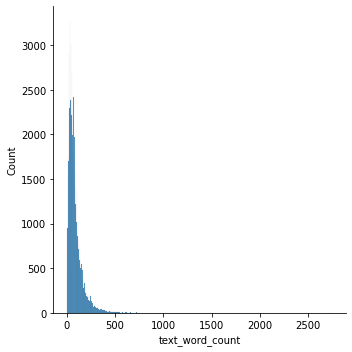

In [176]:
#Looks like the data is skewed to the right. We can transform this data using log transformation techniques
sns.displot(df_new['text_word_count'])

In [177]:
df_new['text_word_count_log'] = np.log(df_new['text_word_count'])

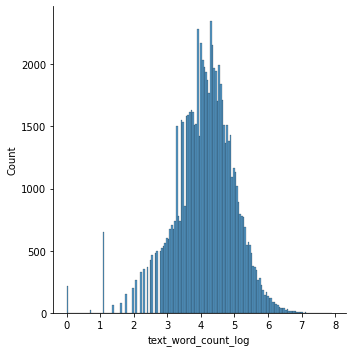

In [179]:
#Data for word count looks much better and centered now
sns.displot(df_new['text_word_count_log'])

In [190]:
#Lets get how many characters we have for each text
df_new['text_char_count'] = df_new['text'].apply(lambda x:sum(len(word) for word in str(x).split(" ")))
df_new['text_char_log'] = np.log(df_new['text_char_count'])

c:\Users\abhis\Documents\feature-eng\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


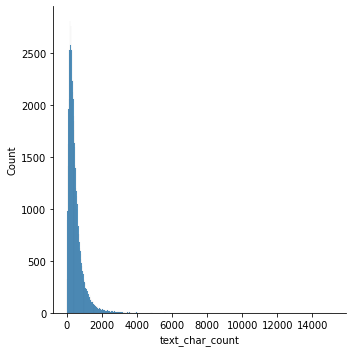

In [192]:
# Right skewed data again in char count
sns.displot(df_new['text_char_count'])

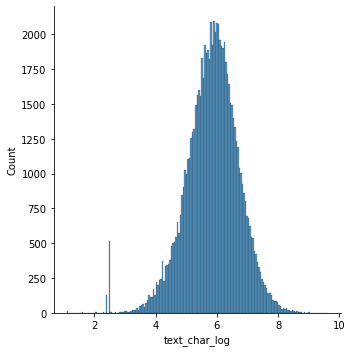

In [193]:
# Log transformation for the character count to center the data
sns.displot(df_new['text_char_log'])

In [196]:
#Average word count
df_new['avg_word_cnt'] = df_new['text_char_count']/df_new['text_word_count']

In [198]:
#Unique words
df_new['unq_words'] = df_new['text'].str.lower().str.split().apply(set).str.len()

In [200]:
df_new['unq_words'].head(2)

0    69
1    38
Name: unq_words, dtype: int64